In [1]:
from __future__ import annotations

import argparse
import json
import pickle
from typing import Tuple
import time
import os
os.environ['LOG_LEVEL'] = 'ERROR'

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from gauntlet.coingecko import CoinGecko
from gauntlet.constants import STABLECOINS
from gauntlet.data_utils import get_drawdowns
from gauntlet.data_utils import get_price_impacts
from gauntlet.logger import get_logger
from gauntlet.sim import get_init_collateral_usd
from gauntlet.sim import heuristic_drawdown
from gauntlet.sim import simulate_insolvency
from gauntlet.coingecko import token_from_symbol_or_address
from gauntlet.tokens import Tokens, Token
from gauntlet.sim import compute_liquidation_incentive
from gauntlet.coingecko import current_price

Collat Token(symbol='crv', address='0xd533a949740bb3306d119cc777fa900ba034cd52', decimals=18, coingecko_id='curve-dao-token') | Borrow Token(symbol='usdc', address='0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', decimals=6, coingecko_id='usd-coin') | Initial collateral: 50.00mil | Repay: 0.0239mil


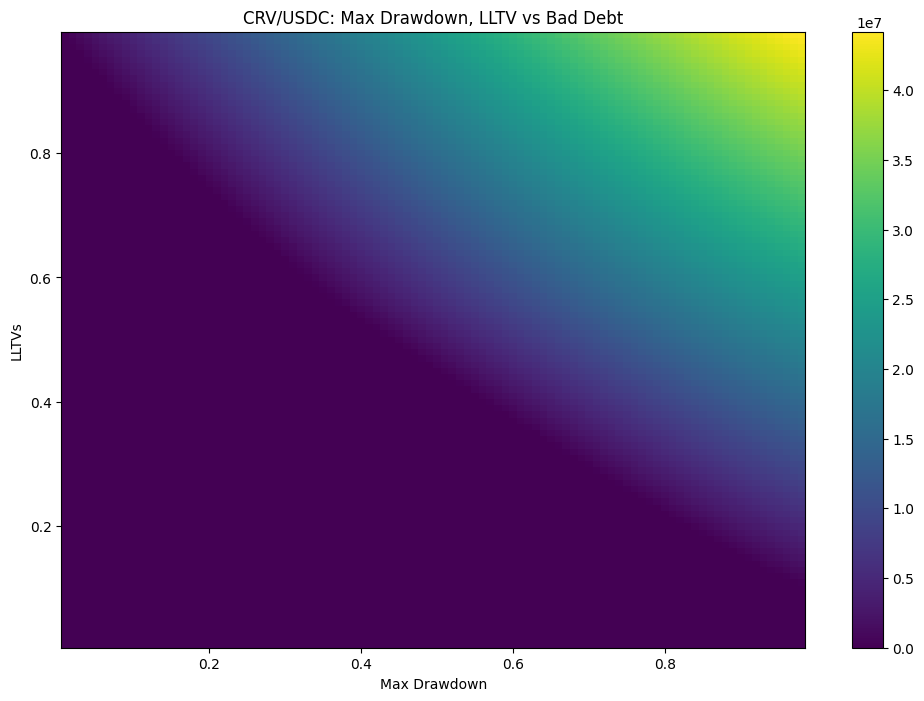

In [2]:
def drawdown_vs_lltv(collat: TokenInfo, debt: TokenInfo):
    '''
    Compute a heatmap of max drawdown and recommended LLTV against bad debt accrued
    '''
    lltvs = np.arange(0.01, 1.0, 0.01)
    max_drawdowns = np.arange(0.01, 0.99, 0.01)
    m = 0.15
    beta = 0.3
    pct_decrease = 0.005
    collat = Tokens.CRV
    debt = Tokens.USDC
    tokens = [collat, debt]
    result_array = np.zeros((len(lltvs), len(max_drawdowns)))
    
    # default values from historical drawdown, price impact
    prices = {t: current_price(t.address) for t in tokens}  
    price_impacts = get_price_impacts(                                                                 
        [collat, debt], update_cache=False, use_cache=True                               
    )              
    repay_amnts = {t: price_impacts[t.symbol]["0.005"] * prices[t] for t in tokens} 
    initial_collateral_usd = get_init_collateral_usd(collat, Tokens.USDC, price_impacts)
    print(f"Collat {collat} | Borrow {debt} | Initial collateral: {initial_collateral_usd / 1e6:.2f}mil | Repay: {repay_amnts[collat]/1e6:.4f}mil")
    
    for i, ltv in enumerate(lltvs):
        for j, dd in enumerate(max_drawdowns):
            lb = compute_liquidation_incentive(m, beta, ltv)
            ins = simulate_insolvency(
                initial_collateral_usd=initial_collateral_usd,
                collateral_price=current_price(collat.address),
                debt_price=1,
                lltv=ltv,
                repay_amount_usd=min(repay_amnts[collat], repay_amnts[debt]),
                liq_bonus=lb,
                max_drawdown=dd,
                pct_decrease=pct_decrease,
            )
            result_array[i, j] = ins
    
    plt.figure(figsize=(12, 8))
    c = plt.pcolormesh(max_drawdowns, lltvs, result_array, cmap='viridis', shading='auto')
    plt.colorbar(c)
    
    plt.xlabel('Max Drawdown')
    plt.ylabel('LLTVs')
    plt.title('CRV/USDC: Max Drawdown, LLTV vs Bad Debt')
    plt.show()

drawdown_vs_lltv(Tokens.CRV, Tokens.USDC)

As the max drawdown increases, we should expect to see lower recommended LLTVs. In the heatmap displayed, we see that the insolvent amount (shown through the color on the heatmap) increases as max drawdown increases.

Collat Token(symbol='uni', address='0x1f9840a85d5af5bf1d1762f925bdaddc4201f984', decimals=18, coingecko_id='uniswap') | Borrow Token(symbol='usdc', address='0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', decimals=6, coingecko_id='usd-coin') | Initial collateral: 50.00mil | Repay: 0.0110mil


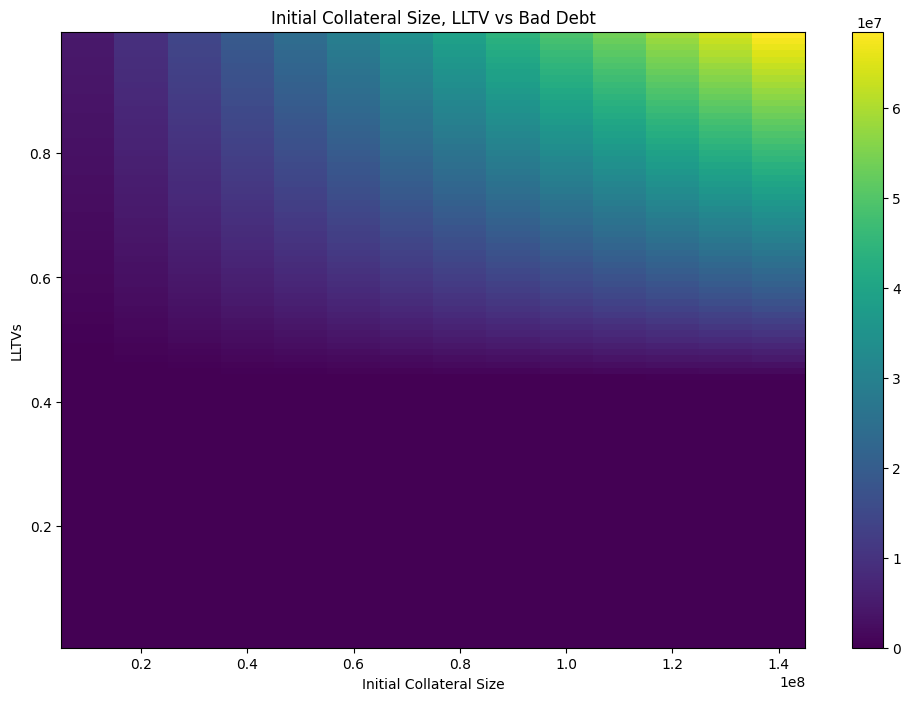

In [3]:
def collateral_size_vs_lltv(collat: TokenInfo, debt: TokenInfo):
    '''
    Compute a heatmap of the initial collateral size's impact against recommended LLTV.
    '''
    lltvs = np.arange(0.01, 1.0, 0.01)
    max_drawdowns = np.arange(0.01, 0.99, 0.01)
    m = 0.15
    beta = 0.3
    pct_decrease = 0.005
    tokens = [collat, debt]
    
    # default values from historical drawdown, price impact
    prices = {t: current_price(t.address) for t in tokens}  
    price_impacts = get_price_impacts(                                                                 
        [collat, debt], update_cache=False, use_cache=True                               
    )              
    repay_amnts = {t: price_impacts[t.symbol]["0.005"] * prices[t] for t in tokens} 
    initial_collateral_usd = get_init_collateral_usd(collat, Tokens.USDC, price_impacts)
    
    print(f"Collat {collat} | Borrow {debt} | Initial collateral: {initial_collateral_usd / 1e6:.2f}mil | Repay: {repay_amnts[collat]/1e6:.4f}mil")
    init_collats = [10_000_000 * i for i in range(1, 15)]
    result_array = np.zeros((len(lltvs), len(init_collats)))
    
    for i, ltv in enumerate(lltvs):
        for j, initial_collateral_usd in enumerate(init_collats):
            lb = compute_liquidation_incentive(m, beta, ltv)
            ins = simulate_insolvency(
                initial_collateral_usd=initial_collateral_usd,
                collateral_price=current_price(collat.address),
                debt_price=1,
                lltv=ltv,
                repay_amount_usd=min(repay_amnts[collat], repay_amnts[debt]),
                liq_bonus=lb,
                max_drawdown=0.5,
                pct_decrease=pct_decrease,
            )
            result_array[i, j] = ins

    plt.figure(figsize=(12, 8))
    c = plt.pcolormesh(init_collats, lltvs, result_array, cmap='viridis', shading='auto')
    plt.colorbar(c)
    
    plt.xlabel('Initial Collateral Size')
    plt.ylabel('LLTVs')
    plt.title('Initial Collateral Size, LLTV vs Bad Debt')
    plt.show()
    
collateral_size_vs_lltv(Tokens.UNI, Tokens.USDC)

Initializing the simulation with a larger initial collateral size means that we need to repay more debt. We expect to see more bad debt accrued as the collateral size increases.

Collat Token(symbol='wbtc', address='0x2260fac5e5542a773aa44fbcfedf7c193bc2c599', decimals=8, coingecko_id='wrapped-bitcoin') | Borrow Token(symbol='usdc', address='0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', decimals=6, coingecko_id='usd-coin') | Initial collateral: 229.78mil | Repay: 3.9166mil


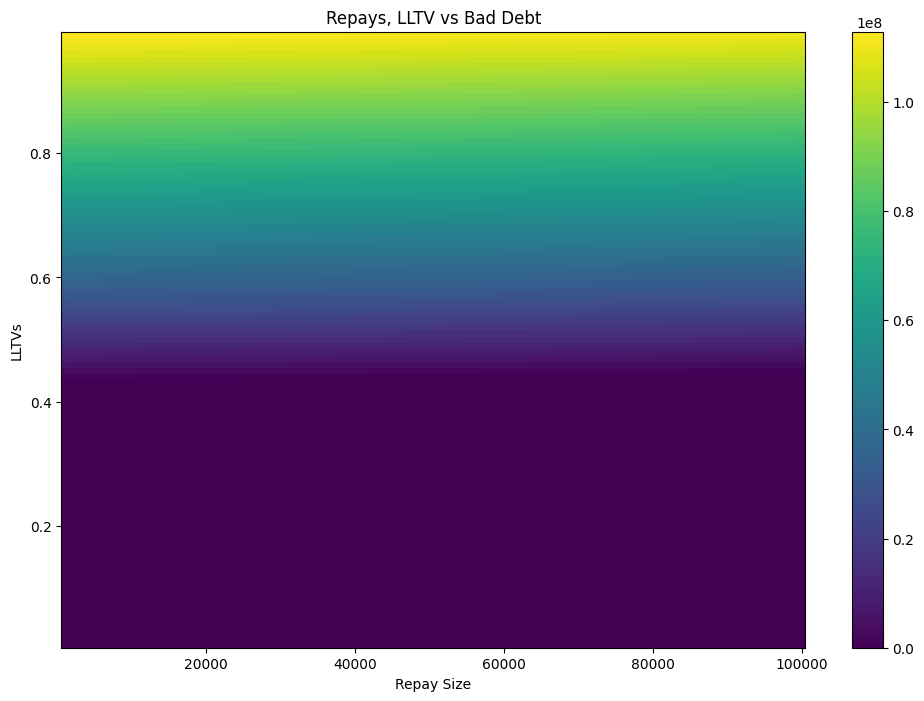

In [4]:
def repay_size(collat: TokenInfo, debt: TokenInfo):
    '''
    Compute a heatmap of the repay size's impact against recommended LLTV.
    '''
    lltvs = np.arange(0.01, 1.0, 0.01)
    max_drawdowns = np.arange(0.01, 0.99, 0.01)
    m = 0.15
    beta = 0.3
    pct_decrease = 0.005
    debt = Tokens.USDC
    tokens = [collat, debt]
    
    # default values from historical drawdown, price impact
    prices = {t: current_price(t.address) for t in tokens}  
    price_impacts = get_price_impacts(                                                                 
        [collat, debt], update_cache=False, use_cache=True                               
    )              
    repay_amnts = {t: price_impacts[t.symbol]["0.005"] * prices[t] for t in tokens} 
    initial_collateral_usd = get_init_collateral_usd(collat, debt, price_impacts)
    
    print(f"Collat {collat} | Borrow {debt} | Initial collateral: {initial_collateral_usd / 1e6:.2f}mil | Repay: {repay_amnts[collat]/1e6:.4f}mil")
    init_collats = [10_000_000 * i for i in range(1, 15)]
    repays = [1_000 * i for i in range(1, 101)]
    result_array = np.zeros((len(lltvs), len(repays)))
    
    for i, ltv in enumerate(lltvs):
        for j, r in enumerate(repays):
            lb = compute_liquidation_incentive(m, beta, ltv)
            ins = simulate_insolvency(
                initial_collateral_usd=initial_collateral_usd,
                collateral_price=current_price(collat.address),
                debt_price=1,
                lltv=ltv,
                repay_amount_usd=r,
                liq_bonus=lb,
                max_drawdown=0.5,
                pct_decrease=pct_decrease,
            )
            result_array[i, j] = ins

    plt.figure(figsize=(12, 8))
    c = plt.pcolormesh(repays, lltvs, result_array, cmap='viridis', shading='auto')
    plt.colorbar(c)
    
    plt.xlabel('Repay Size')
    plt.ylabel('LLTVs')
    plt.title('Repays, LLTV vs Bad Debt')
    plt.show()
    
repay_size(Tokens.WBTC, Tokens.USDC)

If the repay size is too small, we are more likely to accrue bad debt. As repay size increases, the recommended LLTV increases as well.

In [5]:
!LOG_LEVEL=INFO python main.py --collateral weth --borrow usdc

[2023-09-07 18:12:01,505][INFO][main.py:109] Starting
[2023-09-07 18:12:01,776][INFO][sim.py:192] Initial collateral: 360.53mil | Repay usd: 20913180.26 | Max drawdown: 0.35
[2023-09-07 18:12:01,776][INFO][main.py:102] Collat: Token(symbol='weth', address='0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', decimals=18, coingecko_id='weth') | Debt: Token(symbol='usdc', address='0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', decimals=6, coingecko_id='usd-coin') | LI: 0.021 | LLTV: 0.930
